In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split

In [14]:
# Zminimalizowane funkcje do przetworzenia danych wejściowych zawarte w pliku
# data_processing.py - użyte by uniezależnić ten plik od reszty repozytorium

def load_data_from_file(file_name):
    data = pd.read_csv('data/{0}'.format(file_name), header=None).to_numpy()
    COLUMNWISE = 1
    data = np.delete(data, obj=0, axis=COLUMNWISE)
    return data

def load_all_data(num_of_iters):
  data_blocks = []
  for i in range(num_of_iters):
    file_index = i + 1
    file_name_normal = f'data{file_index}_normal.csv'
    file_name_fault = f'data{file_index}_fault.csv'
    normal_data_block = [load_data_from_file(file_name_normal), 1]
    fault_data_block = [load_data_from_file(file_name_fault), 0]
    data_blocks.append(normal_data_block)
    data_blocks.append(fault_data_block)
  return data_blocks

def normalize_data(df):
  for column in df:
    df[column] = df[column] / df[column].max()
  return df

def split_working_faulty_blocks(normalized=False):
  data_blocks = load_all_data(num_of_iters=53)
  data_fault_last = pd.read_csv('data/data54_fault.csv', header=None).to_numpy()
  COLUMNWISE = 1
  data_fault_last = np.delete(data_fault_last, obj=0, axis=COLUMNWISE)
  data_blocks.append([data_fault_last, 0])
  working_blocks = [block[0] for block in data_blocks if block[1] == 1]
  faulty_blocks = [block[0] for block in data_blocks if block[1] == 0]
  working_blocks_np = working_blocks[0].copy()
  faulty_blocks_np = faulty_blocks[0].copy()
  for i in range(len(working_blocks) - 1):
    real_index = i + 1
    working_blocks_np = np.concatenate((working_blocks_np, working_blocks[real_index]), axis=0)
  for i in range(len(faulty_blocks) - 1):
    real_index = i + 1
    faulty_blocks_np = np.concatenate((faulty_blocks_np, faulty_blocks[real_index]), axis=0)
  working_blocks_df = pd.DataFrame(working_blocks_np)
  faulty_blocks_df = pd.DataFrame(faulty_blocks_np)
  if normalized:
    return (normalize_data(working_blocks_df), normalize_data(faulty_blocks_df))
  return (working_blocks_df,faulty_blocks_df)

def time_chunks_split(working_blocks_df, faulty_blocks_df, chunk_size=1):
  working_blocks_rest = len(working_blocks_df) % chunk_size
  faulty_blocks_rest = len(faulty_blocks_df) % chunk_size
  if (working_blocks_rest is not 0):
    working_blocks_df_v2 = working_blocks_df[:-working_blocks_rest]
  else:
    working_blocks_df_v2 = working_blocks_df[:]
  if (faulty_blocks_rest is not 0):
    faulty_blocks_df_v2 = faulty_blocks_df[:-faulty_blocks_rest]
  else:
    faulty_blocks_df_v2 = faulty_blocks_df[:]
  working_blocks_packets_df = np.array_split(working_blocks_df_v2, int(len(working_blocks_df_v2) / chunk_size))
  faulty_blocks_packets_df = np.array_split(faulty_blocks_df_v2, int(len(faulty_blocks_df_v2) / chunk_size))
  working_blocks_packets_with_class = []
  for i in range(len(working_blocks_packets_df)):
    working_blocks_packets_with_class.append( [working_blocks_packets_df[i].to_numpy(), 1] )
  faulty_blocks_packets_with_class = []
  for i in range(len(faulty_blocks_packets_df)):
    faulty_blocks_packets_with_class.append( [faulty_blocks_packets_df[i].to_numpy(), 0] )
  input_list_completed = working_blocks_packets_with_class.copy()
  input_list_completed.extend(faulty_blocks_packets_with_class)
  X = []
  y = []
  for i in range(len(input_list_completed)):
    X.append(input_list_completed[i][0])
    y.append(input_list_completed[i][1])
  return X, y

def train_test_split_with_reshape(X, y, test_size=0.25):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train = np.array(X_train, dtype=float)
  X_test = np.array(X_test, dtype=float)
  y_train = np.array(y_train, dtype=float).reshape(len(y_train), 1) 
  y_test = np.array(y_test, dtype=float).reshape((len(y_test), 1))
  return X_train, X_test, y_train, y_test


ACCURACY: 91.34615384615384


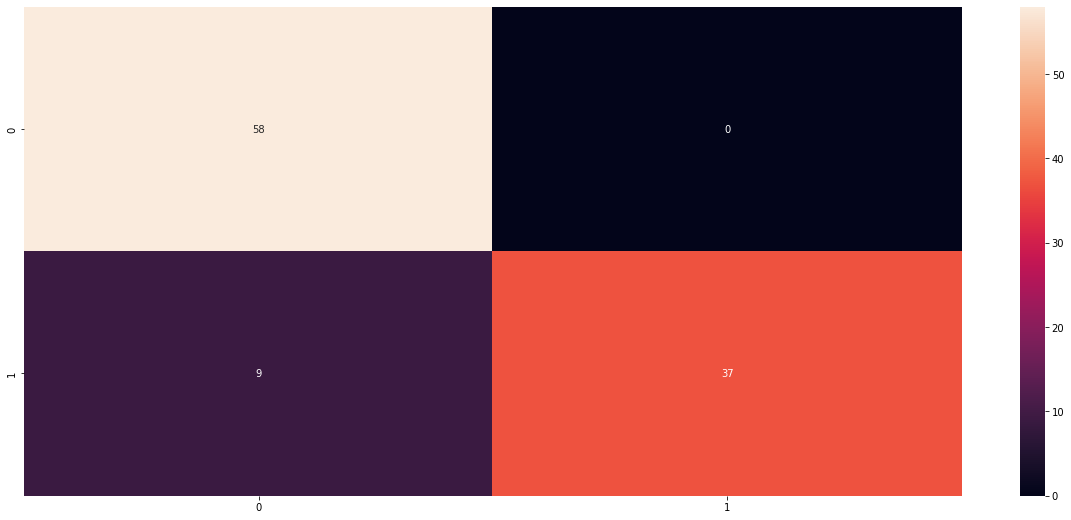

In [15]:
# Dzielimy na bloki działające i awaryjne
working_blocks_df, faulty_blocks_df = split_working_faulty_blocks(True)

# Ustawiamy chunk_size na naszą optymalną wielkość
chunk_size = 8

# Zmieniamy wielkość wykresu
plt.figure(figsize=[21, 9])

# Funkcja tworząca macierz pomyłek, dzięki której ocenimy skuteczność modelu
def create_confusion_matrix(predictions, y):
  confusion_matrix=np.zeros((2, 2))

  for i in range(len(predictions)):
    class_prediction = 0
    if predictions[i] >= 0.5:
      class_prediction = 1

    if class_prediction == y[i]:
      confusion_matrix[class_prediction][class_prediction] += 1
    else:
      confusion_matrix[(class_prediction + 1) % 2][class_prediction] += 1

  return confusion_matrix

# Funkcja wykorzystująca przetrenowany model do przetestowania na zbiorze danych
def test_pretrained_model(model):
  X, y = time_chunks_split(working_blocks_df, faulty_blocks_df, chunk_size=chunk_size)
  X_train, X_test, y_train, y_test = train_test_split_with_reshape(X, y)
  
  predictions = model.predict(X_test)
  confusion_matrix = create_confusion_matrix(predictions, y_test)

  print(f'ACCURACY: {(confusion_matrix[0][0] + confusion_matrix[1][1]) / len(y_test) * 100}')

  sns.heatmap(confusion_matrix, annot=True)

# Ładujemy model i testujemy za pomcą stworzonej funkcji
# Wystarczy zmienić nazwę pliku na jedną z istniejących topologii 
# np. best_model.hdf5 -> model_topology_3.hdf5
model = keras.models.load_model('./pretrained_models/best_model.hdf5')
test_pretrained_model(model)